In [4]:
################################################################################################################################
############################## PRACTICA DL-CV: Jordi Ortega - IA2 ##############################################################
################################################################################################################################

# 0. Hito 1. Modelo Tabular

# 1. Entorno -> Importamos primeras librerías y cargamos el dataset
# 2. Train, Validación y Test -> Partimos el dataset en train, validación y test
# 3. Data Cleaning -> Preprocesamos los datos (entre otros: eliminación de variables, sustitución estadística, variables nuevas)
#     3.1. bloque: id
#     3.2. bloque: url
#     3.3. bloque: texto_libre
#     3.4. bloque: propietario_desc
#     3.5. bloque: piso_desc
#     3.6. bloque: reviews
# 4. Correlación entre variables -> Desplegamos matriz de correlación
# 5. Detección de outliers -> Se eliminan registros con precios 'considerados' outliers
# 6. Resumen análisis completo -> Se juntan los pasos anteriores en una única celda
# 7. Preprocesamiento a validación -> Se aplica en una única celda el preprocesamiento aplicado en training a validación
# 8. Preprocesamiento a test -> Se aplica en una única celda el preprocesamiento aplicado en training a test
# 9. Datos a Red Neuronal -> Lanzamos el algoritmo y conclusiones


In [5]:
################################################################################################################################
############################## ENTORNO PRACTICA ################################################################################
################################################################################################################################

# Al no trabajar desde Jupyter Notebook no necesitamos crear un venv. Colab proporciona un entorno aislado con cada cuaderno.
# Comprobación: Devolvemos la ubicación /usr/bin/python3 del sistema operativo Linux (Ubuntu) sobre el que corre Colab.
import sys
print(sys.executable)

# Comprobamos que librerías vienen en el propio entorno
# !pip freeze

# Las librerías especificas que no vienen de origen las instalaremos directamente desde el cuaderno
# !pip install nombre_paquete

import cv2
import numpy
import pandas
import imageio.v3 as io

from tqdm import tqdm
from typing import Optional, Union

/usr/bin/python3


In [6]:
# Cargamos el dataset
data = pandas.read_csv("dataset.csv", sep = ';')
# Miramos volumetría
print(data.shape)
# Eliminamos los registros que tienen valor nulo en la variable precio (etiqueta o target)
data = data.dropna(subset=['price'])
# Miramos volumetría despues de eliminar registros con price nulo (no existen casos)
print(data.shape)

(7199, 72)
(7199, 72)


In [7]:
# Listamos las variables que componen el dataset
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
       'picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'ava

In [8]:
# Revisamos el dataset en busca de valores duplicados en base al id
duplicados_id = data[data.duplicated(subset='id', keep='first')]
cantidad_duplicados_id = duplicados_id.drop_duplicates(subset='id').shape[0]
print(f'Registros con ids duplicados: {cantidad_duplicados_id}')

Registros con ids duplicados: 3599


In [9]:
# El número anterior es alto, se valora revisar todas las variables (no sólo id)
duplicados_completos = data[data.duplicated(keep='first')]
cantidad_duplicados_completos = duplicados_completos.drop_duplicates().shape[0]
print(f'Registros duplicados en todas las columnas: {cantidad_duplicados_completos}')

Registros duplicados en todas las columnas: 3599


In [10]:
# Eliminamos filas con id duplicado (manteniendo la primera aparición)
data = data.drop_duplicates(subset='id', keep='first')
print(data.shape)

(3600, 72)


In [11]:
################################################################################################################################
############################## TRAIN, VALIDATION AND TEST DATASET ##############################################################
################################################################################################################################

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
import re

# Definimos valores semilla, limpiamos la variables 'price' y preparamos datasets
np.random.seed(42)
tf.random.set_seed(42)

data['price'] = data['price'].apply(lambda valor: float(re.sub(r'[\$\,]', '', valor)))
X = data.loc[:, data.columns != 'price']
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

print(f'Dimensiones del dataset de training: {X_train.shape}')
print(f'Dimensiones del dataset de validación: {X_val.shape}')
print(f'Dimensiones del dataset de test: {X_test.shape}')

# Guardamos físicamente los 3 datasets (por tener origen sin alterar)
X_train.to_csv('train_data.csv', index=False)
y_train.to_csv('train_etiqueta.csv', index=False)
X_val.to_csv('val_data.csv', index=False)
y_val.to_csv('val_etiqueta.csv', index=False)
X_test.to_csv('test_data.csv', index=False)
y_test.to_csv('test_etiqueta.csv', index=False)

Dimensiones del dataset de training: (2016, 71)
Dimensiones del dataset de validación: (504, 71)
Dimensiones del dataset de test: (1080, 71)


In [13]:
################################################################################################################################
############################## DATA CLEANING ###################################################################################
################################################################################################################################

In [14]:
!pip install unidecode
from unidecode import unidecode

# Observaciones genéricas: primeras rows, valores generales con describe() y conteo de nulos y palabras sin significado para posterior procesado
#print(X_train.head(1).T)
#print(X_train.describe())
#pd.set_option('display.max_rows', None)

# Lista de valores ocultos que pudieran esconder nulos (dejamos palabras en castellano y en inglés)
valores_ocultos = ['none', 'desconocido', 'unknown', 'sin datos', 'no disponible','ds', 'not available',
                   'vacio', 'n/a','na', 'sin informacion', 'no especificado', 'no relevante',
                   'sin respuesta', 'irrelevante', 'sin datos disponibles', 'sin contenido',
                   'null', 'no information', 'not specified', 'not relevant',
                   'no response', 'missing', 'empty', 'no data available']

nulos_info = pd.DataFrame(columns=['Número de Nulos', 'Porcentaje Nulos'])

def contar_nulos_y_ocultos(df, valores_ocultos, nulos_info):
    for col in X_train.columns:
        nulos_mask = X_train[col].isna()
        ocultos_mask = X_train[col].astype(str).apply(lambda x: unidecode(x.lower()).strip()).isin(valores_ocultos)
        total_nulos = nulos_mask.sum()
        total_ocultos = ocultos_mask.sum()
        total_count = total_nulos + total_ocultos
        total_records = X_train.shape[0]
        porcentaje_nulos = (total_count / total_records) * 100 if total_records > 0 else 0
        nulos_info.loc[col] = [total_count, porcentaje_nulos]

contar_nulos_y_ocultos(X_train, valores_ocultos, nulos_info)

print(nulos_info)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 20.1 MB/s eta 0:00:00
                                              Número de Nulos  \
id                                                        0.0   
listing_url                                               0.0   
scrape_id                                                 0.0   
last_scraped                                              0.0   
source                                                    0.0   
...                                                       ...   
calculated_host_listings_count                            0.0   
calculated_host_listings_count_entire_homes               0.0   
calculated_host_listings_count_private_rooms              0.0   
calculated_host_listings_count_shared_rooms               0.0   
reviews_per_month                                       525.0   

                                              Porcentaje Nulos  
id                                                    0.000000  
listing_

In [15]:
X_train.dtypes

,0
id,int64
listing_url,object
scrape_id,int64
last_scraped,object
source,object
...,...
calculated_host_listings_count,int64
calculated_host_listings_count_entire_homes,int64
calculated_host_listings_count_private_rooms,int64
calculated_host_listings_count_shared_rooms,int64


In [16]:
# Ordenamos las variables en bloques para determinar posibles acciones de 'cleaning' (rellenar nulos y conversión a numéricas):
# Bloques: id, url, piso_desc, propietario_desc,texto_libre, reviews
# Las variables "calculated" parecen agregados a nivel cliente (no a nivel id de la tabla, es decir, de cada una de las propiedades)
# Las variables relacionadas con el número de noches reservables no parecen (o no lo he identificado) tener un calculo claro o bien se calcularon y luego se
# dividió el archivo "dataset". Ejemplo host_id='319011975' donde minimum_nights=1 pero minimum_minimum_nights=2

# Se excluyen variables con valores nulos o 'valores_ocultos' > 95%
columnas_ocultas = ['neighbourhood_group_cleansed','bathrooms','bedrooms','calendar_updated']
X_train = X_train.drop(columnas_ocultas, axis=1)

In [17]:
# ------> bloque: id (se consideran también como id las fechas que recojen la acción de scraping)
# mantenemos host_id por considerarla categórica (característica común entre apartametos de un mismo propietario)
columnas_id = ['id','scrape_id','last_scraped','calendar_last_scraped']
X_train = X_train.drop(columnas_id, axis=1)

In [18]:
# ------> bloque: url
# Buscamos metadatos en las url, pero no parecen contener información útil.
columnas_url = ['listing_url','picture_url','host_url','host_thumbnail_url','host_picture_url']

# Convertiremos estas variables en 1 y 0 (para reflejar 'variable informada' o 'variable no informada')
for columna in columnas_url:
    X_train[columna] = X_train[columna].notna().astype(int)

20 palabras más comunes:
stay: 1005
Boston: 951
home: 897
experience: 729
apartment: 719
love: 531
enjoy: 464
provide: 464
youll: 443
apartments: 430
guests: 421
travel: 384
stays: 382
team: 375
providing: 355
years: 344
one: 333
world: 331
furnished: 324
every: 318


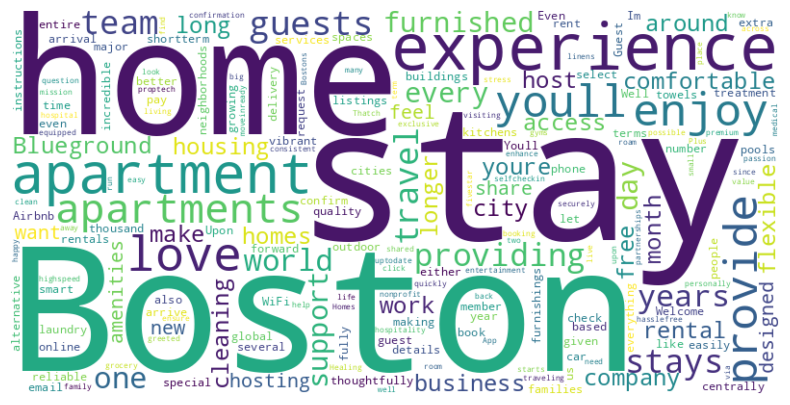

In [19]:
import matplotlib.pyplot as plt

# ------> bloque: texto_libre
# Revisamos el contenido de la variable de este bloque para decidir como tratar esta variable de texto libre.
# Con la variable de texto libre haremos 2 acciones:
#      1. contar carácteres
#      2. variable informada o no informada
#      3. nube de palabras (supongo que en modulos próximos veremos como tratar mejor este tipo de variables...exigirían tokenización y un análisis con NLP)

# Contamos carácteres de la variable Description
X_train['host_about_char_count'] = X_train['host_about'].astype(str).str.len()

# Convertimos estas variables en 1 y 0 (para reflejar 'variable informada' o 'variable no informada')
columnas_host = ['host_about']
for columna_h in columnas_host:
    X_train[columna_h + '_lg'] = X_train[columna_h].notna().astype(int)

# Nube de palabras para crearnos un flag que califique el registro como novedoso o no
from collections import Counter
from wordcloud import WordCloud
import string

stop_words = set([
    # Stop words en español
    "el", "la", "un", "una", "los", "las", "en", "y", "de", "que", "a",
    "es", "se", "por", "con", "para", "no", "lo", "su", "más", "este",
    "está", "tiene", "como", "me", "o", "del", "al", "una", "sus", "mi",
    "también", "muy", "entre", "ser", "sin", "sobre", "si", "cuando",

    # Stop words en inglés
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves",
    "you", "your", "yours", "yourself", "yourselves", "he", "him",
    "his", "himself", "she", "her", "hers", "herself", "it", "its",
    "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those",
    "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing",
    "a", "an", "the", "and", "but", "if", "or", "because", "as",
    "until", "while", "of", "at", "by", "for", "with", "about",
    "against", "between", "into", "through", "during", "before",
    "after", "above", "below", "to", "from", "up", "down", "in",
    "out", "on", "off", "over", "under", "again", "further",
    "then", "once", "here", "there", "when", "where", "why",
    "how", "all", "any", "both", "each", "few", "more", "most",
    "other", "some", "such", "no", "nor", "not", "only", "own",
    "same", "so", "than", "too", "very", "s", "t", "can", "will",
    "just", "don", "should", "now"
])

text = " ".join(
    X_train['host_about']
    .dropna()
    .astype(str)
    .apply(unidecode)
)

text = text.translate(str.maketrans('', '', string.punctuation))
filtered_words = [word for word in text.split() if word.lower() not in stop_words]
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(20)
print("20 palabras más comunes:")
for word, count in most_common_words:
    print(f"{word}: {count}")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
# Creamos una lista con las palabras comunes
top_words = ['Boston', 'stay', 'experience', 'love', 'home',
             'travel', 'furnished', 'stays', 'rental', 'provide',
             'year', 'guests', 'providing', 'apartments', 'youre',
             'city', 'Im', 'business', 'team', 'comfortable']

def revisa_top_words(text):
    if pd.isna(text):
        return 2
    text = unidecode(str(text)).lower()
    for word in top_words:
        if word in text:
            return 0
    return 1

# Aplicamos la función a la columna 'host_about' y creamos la nueva columna 'original_lg'
X_train['original_lg'] = X_train['host_about'].apply(revisa_top_words)

columnas_texto_libre = ['host_about']
X_train = X_train.drop(columnas_texto_libre, axis=1)

In [21]:
# ------> bloque: propietario_desc
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Hacemos split de la columna 'host_location'
def dividir_host_location(host_location):
    if pd.isna(host_location):
        return pd.Series([None, None])
    parts = host_location.split(',')
    while len(parts) < 2:
        parts.append(None)
    return pd.Series(parts[:2])

# Aplicamos la función y creamos las nuevas columnas, eliminamos espacios y rellenamos nulos
X_train[['host_geo1', 'host_geo2']] = X_train['host_location'].apply(dividir_host_location)
X_train['host_geo1'] = X_train['host_geo1'].str.strip()
X_train['host_geo2'] = X_train['host_geo2'].str.strip()
X_train['host_geo1'] = X_train['host_geo1'].fillna('desconocido_ajuste')
X_train['host_geo2'] = X_train['host_geo2'].fillna('desconocido_ajuste')

oe_host_geo1 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe_host_geo2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train['host_geo1'] = oe_host_geo1.fit_transform(X_train[['host_geo1']])
X_train['host_geo2'] = oe_host_geo2.fit_transform(X_train[['host_geo2']])


In [22]:
# Convertimos a númerica host_response_time
for columna in ['host_response_time']:
    print(f"Valores únicos en {columna}: {X_train[columna].unique()}")

response_time_mapping = {
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1,
    np.nan: 0
}

X_train['host_response_time'] = X_train['host_response_time'].map(response_time_mapping)
X_train['host_response_time'].fillna(0, inplace=True)

for columna in ['host_response_time']:
    print(f"Valores únicos en {columna}: {X_train[columna].unique()}")

Valores únicos en host_response_time: ['within an hour' 'within a few hours' nan 'within a day'
 'a few days or more']
Valores únicos en host_response_time: [4 3 0 2 1]


<ipython-input-22-674be396ca2f>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['host_response_time'].fillna(0, inplace=True)


In [23]:
# Rellenamos con 0 los valores nulos de 'host_response_rate' y formateamos
X_train['host_response_rate'] = X_train['host_response_rate'].fillna(0).astype(str)
X_train['host_response_rate'] = X_train['host_response_rate'].apply(lambda valor: float(re.sub(r'%', '', valor)))

# Rellenamos host_neighbourhood con otros host_neighbourhood si el host_id es igual, en caso contrario devolvemos la string 'desconocido_ajuste' para diferenciarlos de las palabras 'ocultas'
def rellenar_nan(row, columna_a_rellenar, columna_referencia, df):
    if pd.isna(row[columna_a_rellenar]):
        if pd.isna(row[columna_referencia]):
            return 'desconocido_ajustado'
        referencia = df[df[columna_referencia] == row[columna_referencia]]
        valores_validos = referencia[columna_a_rellenar].dropna()
        if not valores_validos.empty:
            return valores_validos.iloc[0]
        else:
            return 'desconocido_ajustado'

    return row[columna_a_rellenar]

X_train['host_neighbourhood'] = X_train.apply(rellenar_nan, axis=1,
                               args=('host_neighbourhood', 'host_id', X_train))

# Creamos encoders
oe_host_neighbourhood = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['host_neighbourhood'] = oe_host_neighbourhood.fit_transform(X_train[['host_neighbourhood']])

# En host_acceptance_rate (entendemos que nulo igual a 0)
X_train['host_acceptance_rate'] = X_train['host_acceptance_rate'].fillna('0').astype(str)
X_train['host_acceptance_rate'] = X_train['host_acceptance_rate'].apply(lambda valor: float(re.sub(r'%', '', valor)))

# host_is_superhost convertimos a 1 los true
X_train['host_is_superhost'] = (X_train['host_is_superhost'] == 't').astype(int)

# Usamos la variable Host Since para reportar el año de creacion
X_train['enrollment_year'] = pd.to_datetime(X_train['host_since'],errors='coerce').apply(lambda x: 2024-x.year)

# host_verifications Contamos verificaciones por registro
def count_verifications(verifications):
    if pd.isna(verifications):
        return 0
    return len(set(verifications.split(',')))

# Aplicamos la función y creamos una nueva columna 'verification_count'
X_train['host_verifications_count'] = X_train['host_verifications'].apply(count_verifications)

# host_has_profile_pic convertimos a 1 los true
X_train['host_has_profile_pic'] = (X_train['host_has_profile_pic'] == 't').astype(int)

# host_identity_verified convertimos a 1 los true
X_train['host_identity_verified'] = (X_train['host_identity_verified'] == 't').astype(int)

In [24]:
# Drop de variables
columnas_prop_desc = ['host_name','host_since','host_location','host_verifications']
X_train = X_train.drop(columnas_prop_desc, axis=1)

In [25]:
# ------> bloque: reviews
# Usamos la variable First Review and Last Review para reportar el año de creación
X_train['first_review'] = pd.to_datetime(X_train['first_review']).apply(lambda x: 2024-x.year)
X_train['last_review'] = pd.to_datetime(X_train['last_review']).apply(lambda x: 2024-x.year)

# Asignamos a los nulos un valor predeterminado
X_train['first_review'] = X_train['first_review'].fillna(-1)
X_train['last_review'] = X_train['last_review'].fillna(-1)

In [26]:
# Para las reviews asumimos que puntua la gente muy contenta o muy enfada, por esto llenaremos nulls con la media
reviews_to_fill = ['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']

for col in reviews_to_fill:
    X_train[col].fillna(X_train[col].mean(), inplace=True)

<ipython-input-26-d59e3a20627a>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(X_train[col].mean(), inplace=True)


In [27]:
# ------> bloque: piso_desc
# Se estudian estas 2 variables y se busca la relación entre ellas
X_train_neigh = X_train[['neighbourhood', 'neighbourhood_cleansed']]
#X_train_neigh.head(20)
# Revisamos cuántos valores NaN hay por columna y valores únicos
print(f'El dataframe tiene un total de {len(X_train_neigh)} filas.')
len(X_train_neigh) - X_train_neigh.count()
X_train_neigh.apply(lambda x: len(x.unique()))

# Se decide rellenar en base a otros registros de neighbourhood_cleansed que tengan el mismo valor neighbourhood
X_train['neighbourhood'] = X_train.apply(rellenar_nan, axis=1,
                               args=('neighbourhood', 'neighbourhood_cleansed', X_train))

conteo_desconocido_neighbourhood = (X_train['neighbourhood'] == 'desconocido_ajustado').sum()

print(f"Número de 'desconocido_ajustado' en 'neighbourhood': {conteo_desconocido_neighbourhood}")

oe_neighbourhood = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['neighbourhood'] = oe_neighbourhood.fit_transform(X_train[['neighbourhood']])

oe_neighbourhood_cleansed= OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['neighbourhood_cleansed'] = oe_neighbourhood_cleansed.fit_transform(X_train[['neighbourhood_cleansed']])

El dataframe tiene un total de 2016 filas.
Número de 'desconocido_ajustado' en 'neighbourhood': 6


In [28]:
# En source convertimos a 1 los true
X_train['source'] = (X_train['source'] == 'city scrape').astype(int)

In [29]:
# Creamos OrdinalEncoder
oe_property_type = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['property_type'] = oe_property_type.fit_transform(X_train[['property_type']])

oe_room_type = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['room_type'] = oe_room_type.fit_transform(X_train[['room_type']])

In [30]:
# Convertimos a numérica la variable bathrooms_text
X_train['bathrooms_text'] = X_train['bathrooms_text'].apply(
    lambda valor: float(re.sub(r'[^\d.]', '', str(valor))) if re.search(r'\d', str(valor)) else 0.5
)

In [31]:
# La variable beds se asigna con una media según el grupo de accommodates y se trunca
mean_beds = X_train.groupby('accommodates')['beds'].mean().round()
X_train['beds'] = np.where(X_train['beds'].isnull(), X_train['accommodates'].map(mean_beds), X_train['beds'])

In [32]:
# contamos características (¿se podrían ponderar en función de importancia?)
X_train['amenities'].fillna("", inplace=True)
X_train['amenities'] = X_train['amenities'].apply(lambda x: len(str(x).split(',')))

# convertimos a númerica has_availability
X_train['has_availability'] = (X_train['has_availability'] == 't').astype(int)

# Pasamos a mayusculas para homogenizar valores y rellenamos valores nulos
X_train['license'] = X_train['license'].apply(lambda valor: str(valor).upper() if pd.notnull(valor) else 'DESCONOCIDO_AJUSTE')

# Creamos encoders
oe_license = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train['license'] = oe_license.fit_transform(X_train[['license']])

# convertimos a númerica instant_bookable
X_train['instant_bookable'] = (X_train['instant_bookable'] == 't').astype(int)

<ipython-input-32-ae5c245fa37c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['amenities'].fillna("", inplace=True)


In [33]:
# Comproamos que no hay valores nulos ni "ocultos" y que las variables son numéricas
valores_ocultos = ['none', 'desconocido', 'unknown', 'sin datos', 'no disponible','ds', 'not available',
                   'vacio', 'n/a','na', 'sin informacion', 'no especificado', 'no relevante',
                   'sin respuesta', 'irrelevante', 'sin datos disponibles', 'sin contenido',
                   'null', 'no information', 'not specified', 'not relevant',
                   'no response', 'missing', 'empty', 'no data available']

nulos_info = pd.DataFrame(columns=['Número de Nulos', 'Porcentaje Nulos'])

def contar_nulos_y_ocultos(df, valores_ocultos, nulos_info):
    for col in X_train.columns:
        nulos_mask = X_train[col].isna()
        ocultos_mask = X_train[col].astype(str).apply(lambda x: unidecode(x.lower()).strip()).isin(valores_ocultos)
        total_nulos = nulos_mask.sum()
        total_ocultos = ocultos_mask.sum()
        total_count = total_nulos + total_ocultos
        total_records = X_train.shape[0]
        porcentaje_nulos = (total_count / total_records) * 100 if total_records > 0 else 0
        nulos_info.loc[col] = [total_count, porcentaje_nulos]

contar_nulos_y_ocultos(X_train, valores_ocultos, nulos_info)

print(nulos_info)

                          Número de Nulos  Porcentaje Nulos
listing_url                           0.0               0.0
source                                0.0               0.0
picture_url                           0.0               0.0
host_id                               0.0               0.0
host_url                              0.0               0.0
...                                   ...               ...
original_lg                           0.0               0.0
host_geo1                             0.0               0.0
host_geo2                             0.0               0.0
enrollment_year                       0.0               0.0
host_verifications_count              0.0               0.0

[65 rows x 2 columns]


In [34]:
X_train.dtypes

,0
listing_url,int64
source,int64
picture_url,int64
host_id,int64
host_url,int64
...,...
original_lg,int64
host_geo1,float64
host_geo2,float64
enrollment_year,int64


In [35]:
################################################################################################################################
############################## CORRELACION ENTRE VARIABLES #####################################################################
################################################################################################################################

In [36]:
X_train.corr()

,listing_url,source,picture_url,host_id,host_url,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_about_char_count,host_about_lg,original_lg,host_geo1,host_geo2,enrollment_year,host_verifications_count
listing_url,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
source,NaN,1.000000,NaN,0.073201,NaN,0.376343,0.370003,0.369750,0.058646,NaN,...,0.059700,0.019203,0.136414,0.104780,0.116732,-0.122456,-0.048931,-0.009123,-0.048504,0.013126
picture_url,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,NaN,0.073201,NaN,1.000000,NaN,0.105878,0.085763,0.132752,-0.102767,NaN,...,0.108142,-0.014592,0.164801,-0.215370,-0.163681,0.166405,0.322197,0.345284,-0.948510,-0.279776
host_url,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
original_lg,NaN,-0.122456,NaN,0.166405,NaN,-0.173853,-0.163152,-0.240919,-0.054166,NaN,...,-0.154903,-0.013604,-0.043515,-0.622891,-0.957960,1.000000,0.210824,0.209911,-0.206346,-0.311242
host_geo1,NaN,-0.048931,NaN,0.322197,NaN,-0.043759,-0.044949,-0.022987,-0.151034,NaN,...,0.294146,0.028228,0.036963,0.043975,-0.234247,0.210824,1.000000,0.894919,-0.333410,-0.029412
host_geo2,NaN,-0.009123,NaN,0.345284,NaN,-0.040268,-0.043675,-0.017580,-0.134940,NaN,...,0.309988,0.036452,0.070923,-0.007086,-0.226155,0.209911,0.894919,1.000000,-0.346675,-0.099647
enrollment_year,NaN,-0.048504,NaN,-0.948510,NaN,-0.073468,-0.056616,-0.101934,0.110915,NaN,...,-0.059149,0.007391,-0.159604,0.224005,0.208804,-0.206346,-0.333410,-0.346675,1.000000,0.264090


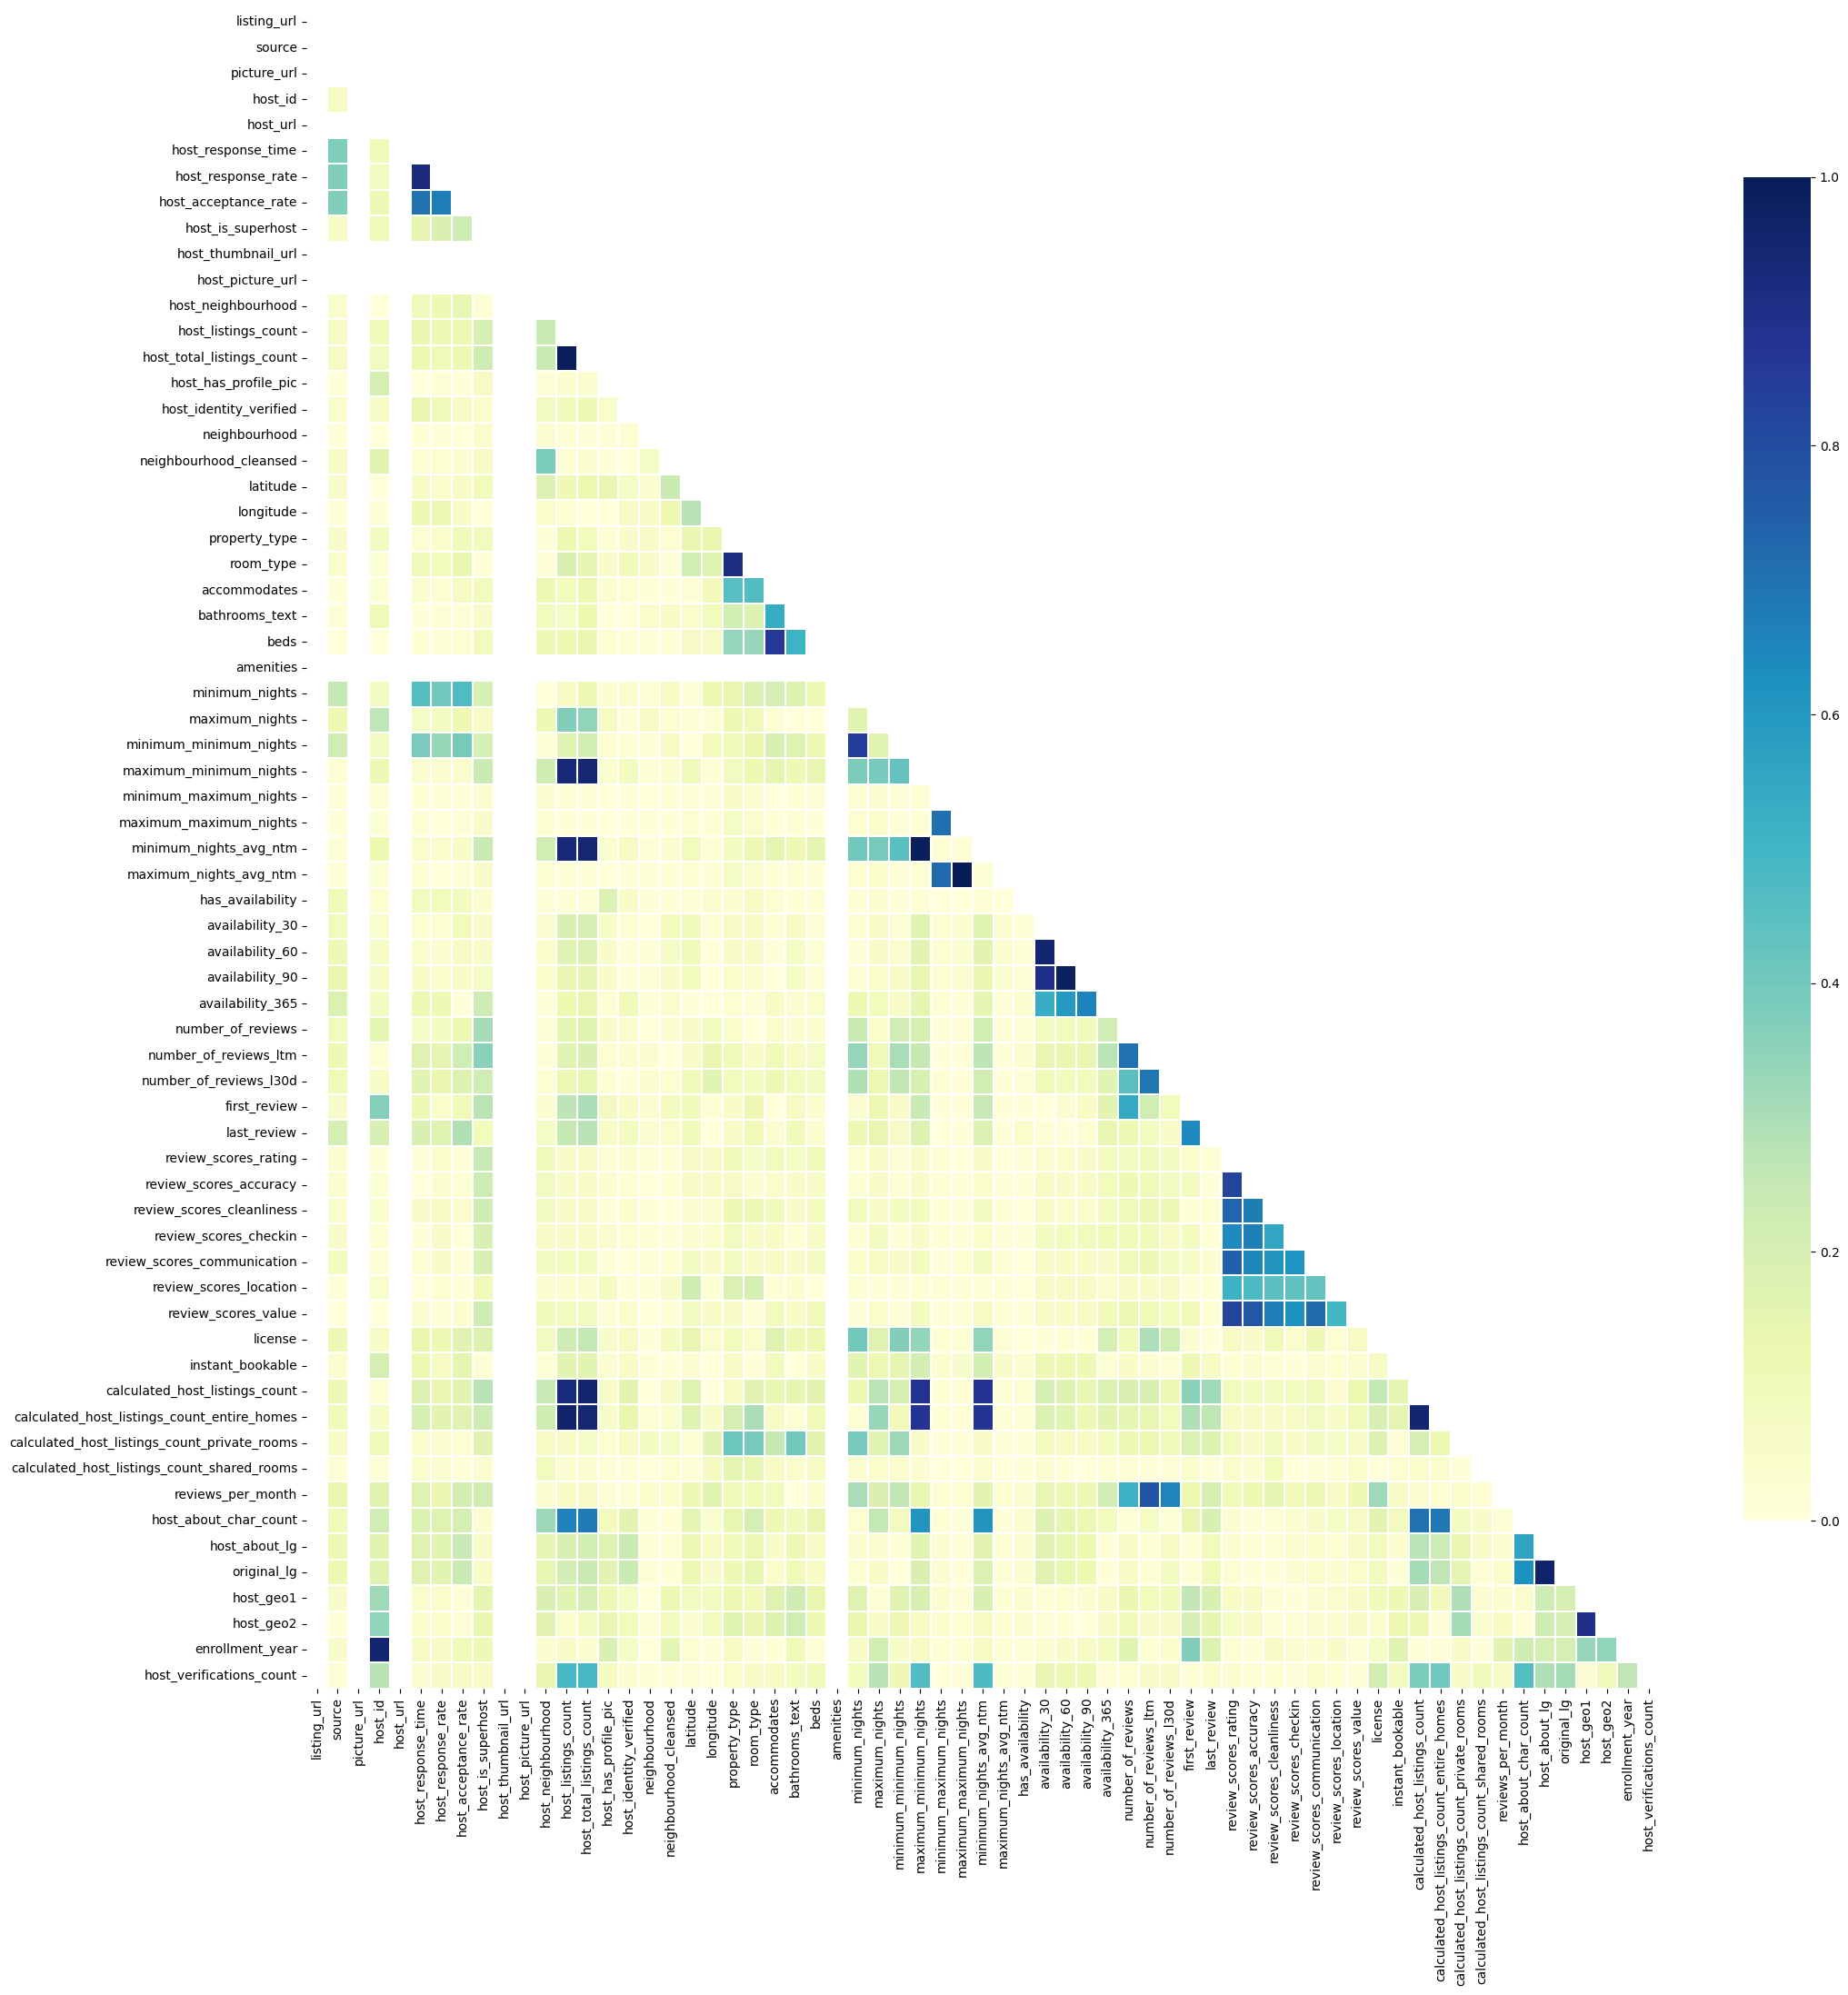

In [37]:
import seaborn as sns

# Pintamos la matriz de correlación de variables
corr = np.abs(X_train.corr())
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})
plt.show()

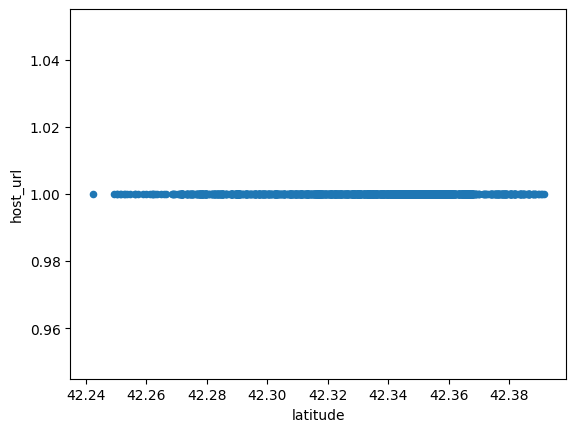

In [38]:
# Pintamos Host URL por confirmar que es totalmente independiente. Eliminaremos también el resto de variables que son independientes.
X_train.plot(kind = 'scatter',x='latitude',y = 'host_url')
plt.xlabel('latitude')
plt.ylabel('host_url')
plt.show()

X_train.drop(['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url',
         'host_picture_url', 'amenities'], axis=1, inplace=True)



In [39]:
# Listamos correlaciones muy altas (0.9)
numeric_columns = X_train.select_dtypes(include=['number']).columns
correlation_matrix = X_train[numeric_columns].corr()

threshold = 0.9
correlated_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)

for (var1, var2), correlation in correlated_pairs.items():
    if var1 != var2 and correlation > threshold:
        print(f"Variables: {var1} y {var2} - Correlación: {correlation:.2f}")

Variables: maximum_maximum_nights y maximum_nights_avg_ntm - Correlación: 1.00
Variables: maximum_nights_avg_ntm y maximum_maximum_nights - Correlación: 1.00
Variables: minimum_nights_avg_ntm y maximum_minimum_nights - Correlación: 0.99
Variables: maximum_minimum_nights y minimum_nights_avg_ntm - Correlación: 0.99
Variables: host_total_listings_count y host_listings_count - Correlación: 0.99
Variables: host_listings_count y host_total_listings_count - Correlación: 0.99
Variables: availability_60 y availability_90 - Correlación: 0.98
Variables: availability_90 y availability_60 - Correlación: 0.98
Variables: host_about_lg y original_lg - Correlación: 0.96
Variables: original_lg y host_about_lg - Correlación: 0.96
Variables: calculated_host_listings_count_entire_homes y host_listings_count - Correlación: 0.96
Variables: host_listings_count y calculated_host_listings_count_entire_homes - Correlación: 0.96
Variables: availability_30 y availability_60 - Correlación: 0.95
Variables: availabi

In [40]:
# Motivados por tener un dataset con pocos registros pero con un número grande de características, eliminaremos también aquellas variables que están muy correlacionadas entre ellas, dejando una del par.
X_train.drop(['maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'host_total_listings_count', 'availability_60',
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count','maximum_minimum_nights','original_lg','host_id','maximum_maximum_nights','host_response_time','room_type'], axis=1, inplace=True)


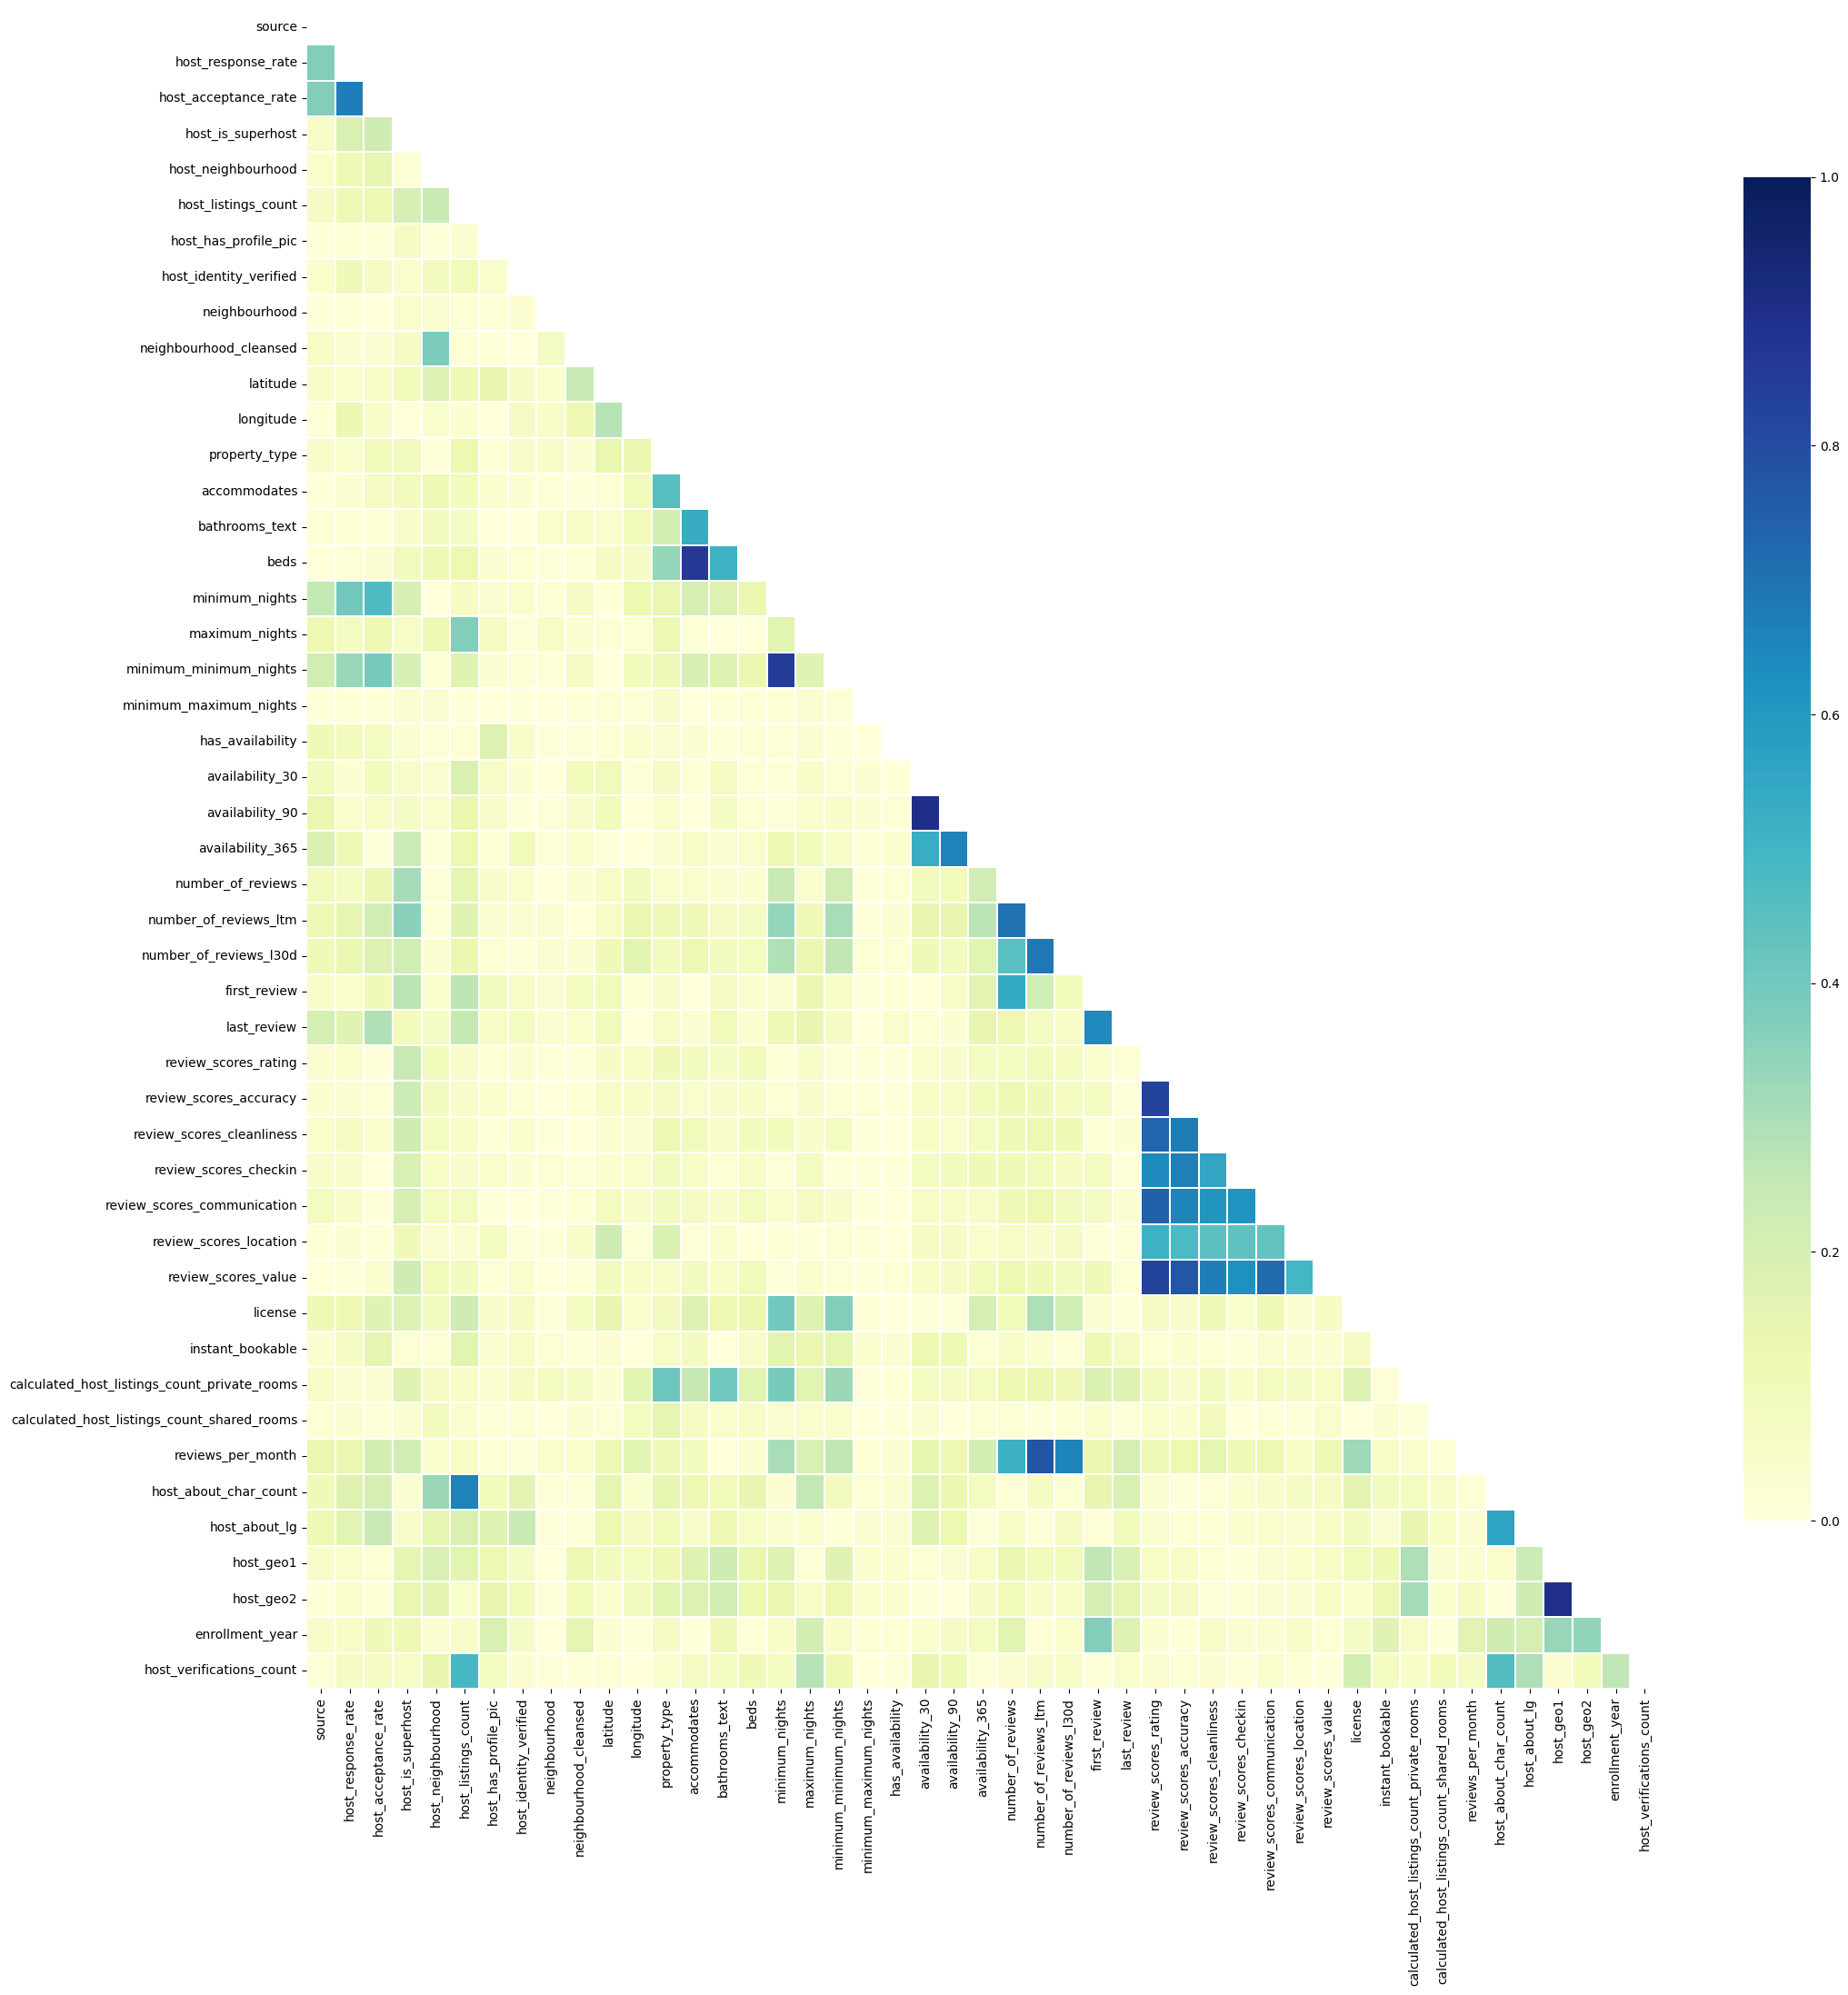

In [41]:
# Pintamos de nuevo la matriz de correlación, ahora simplificada
corr = np.abs(X_train.corr())
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})
plt.show()

In [42]:
################################################################################################################################
############################## DETECCIÓN OUTLIERS ##############################################################################
################################################################################################################################

Index(['price'], dtype='object')
Cantidad de valores nulos en 'price': 0


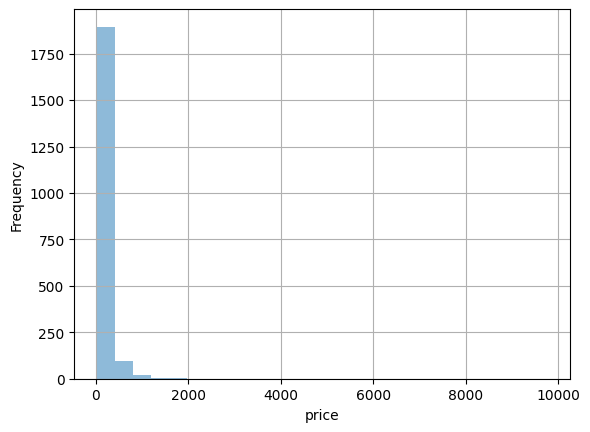

In [43]:
# Estudiamos la variable price para eliminar outliers. Eliminares tambiñen los índices de X_train..
y_train = pd.DataFrame(y_train)
print(y_train.columns)
y_train.shape
num_nulos = y_train['price'].isna().sum()
print(f"Cantidad de valores nulos en 'price': {num_nulos}")

y_train['price'].plot.hist(alpha=0.5, bins=25, grid = True)
plt.xlabel('price')

plt.show()

In [44]:
# Revisamos volumetrías, eliminamos registros y equilibramos índices
len(y_train[y_train['price'] > 800])


indices_originales = y_train.index
y_train = y_train[y_train['price'] < 801]
indices_eliminados = indices_originales.difference(y_train.index)
X_train = X_train.drop(indices_eliminados)


In [45]:
# Guardamos los nombres de las columnas, posteriormente serán útiles para reconvertir el array que exige la red neuronal a pandas dataframe
X_train.columns

Index(['source', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'accommodates', 'bathrooms_text', 'beds', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'minimum_maximum_nights',
       'has_availability', 'availability_30', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_mont

In [46]:
X_train.shape

(1988, 47)

In [47]:
################################################################################################################################
############################## RESUMEN ANÁLISIS COMPLETO #######################################################################
################################################################################################################################

In [48]:
# Combinamos todo el preprocesamiento en una única celda
X_train = pandas.read_csv("train_data.csv", sep = ',')

X_train = X_train.drop(columnas_ocultas, axis=1)
# ------> bloque: id
X_train = X_train.drop(columnas_id, axis=1)
# ------> bloque: url
for columna in columnas_url:
    X_train[columna] = X_train[columna].notna().astype(int)
# ------> bloque: texto_libre
X_train['host_about_char_count'] = X_train['host_about'].astype(str).str.len()
columnas_host = ['host_about']
for columna_h in columnas_host:
    X_train[columna_h + '_lg'] = X_train[columna_h].notna().astype(int)
X_train['original_lg'] = X_train['host_about'].apply(revisa_top_words)
columnas_texto_libre = ['host_about']
X_train = X_train.drop(columnas_texto_libre, axis=1)
# ------> bloque: propietario_desc
X_train[['host_geo1', 'host_geo2']] = X_train['host_location'].apply(dividir_host_location)
X_train['host_geo1'] = X_train['host_geo1'].str.strip()
X_train['host_geo2'] = X_train['host_geo2'].str.strip()
X_train['host_geo1'] = X_train['host_geo1'].fillna('desconocido_ajuste')
X_train['host_geo2'] = X_train['host_geo2'].fillna('desconocido_ajuste')
X_train['host_geo1'] = oe_host_geo1.fit_transform(X_train[['host_geo1']])
X_train['host_geo2'] = oe_host_geo2.fit_transform(X_train[['host_geo2']])
X_train['host_verifications_count'] = X_train['host_verifications'].apply(count_verifications)
X_train['host_response_time'] = X_train['host_response_time'].map(response_time_mapping)
X_train['host_response_time'].fillna(0, inplace=True)
X_train['host_response_rate'] = X_train['host_response_rate'].fillna(0).astype(str)
X_train['host_response_rate'] = X_train['host_response_rate'].apply(lambda valor: float(re.sub(r'%', '', valor)))
X_train['host_neighbourhood'] = X_train.apply(rellenar_nan, axis=1,
                               args=('host_neighbourhood', 'host_id', X_train))
X_train['host_neighbourhood'] = oe_host_neighbourhood.fit_transform(X_train[['host_neighbourhood']])
X_train['host_acceptance_rate'] = X_train['host_acceptance_rate'].fillna('0').astype(str)
X_train['host_acceptance_rate'] = X_train['host_acceptance_rate'].apply(lambda valor: float(re.sub(r'%', '', valor)))
X_train['host_is_superhost'] = (X_train['host_is_superhost'] == 't').astype(int)
X_train['enrollment_year'] = pd.to_datetime(X_train['host_since'],errors='coerce').apply(lambda x: 2024-x.year)
X_train['host_verifications_count'] = X_train['host_verifications'].apply(count_verifications)
X_train['host_has_profile_pic'] = (X_train['host_has_profile_pic'] == 't').astype(int)
X_train['host_identity_verified'] = (X_train['host_identity_verified'] == 't').astype(int)
X_train = X_train.drop(columnas_prop_desc, axis=1)
# ------> bloque: reviews
X_train['first_review'] = pd.to_datetime(X_train['first_review']).apply(lambda x: 2024-x.year)
X_train['last_review'] = pd.to_datetime(X_train['last_review']).apply(lambda x: 2024-x.year)
X_train['first_review'] = X_train['first_review'].fillna(-1)
X_train['last_review'] = X_train['last_review'].fillna(-1)
for col in reviews_to_fill:
    X_train[col].fillna(X_train[col].mean(), inplace=True)
# ------> bloque: piso_desc
X_train['neighbourhood'] = X_train.apply(rellenar_nan, axis=1,
                               args=('neighbourhood', 'neighbourhood_cleansed', X_train))
X_train['neighbourhood'] = oe_neighbourhood.fit_transform(X_train[['neighbourhood']])
X_train['neighbourhood_cleansed'] = oe_neighbourhood_cleansed.fit_transform(X_train[['neighbourhood_cleansed']])
X_train['source'] = (X_train['source'] == 'city scrape').astype(int)
X_train['property_type'] = oe_property_type.fit_transform(X_train[['property_type']])
X_train['room_type'] = oe_room_type.fit_transform(X_train[['room_type']])
X_train['bathrooms_text'] = X_train['bathrooms_text'].apply(
    lambda valor: float(re.sub(r'[^\d.]', '', str(valor))) if re.search(r'\d', str(valor)) else 0.5
)
mean_beds = X_train.groupby('accommodates')['beds'].mean().round()
X_train['beds'] = np.where(X_train['beds'].isnull(), X_train['accommodates'].map(mean_beds), X_train['beds'])
X_train['amenities'].fillna("", inplace=True)
X_train['amenities'] = X_train['amenities'].apply(lambda x: len(str(x).split(',')))
X_train['has_availability'] = (X_train['has_availability'] == 't').astype(int)
X_train['license'] = X_train['license'].apply(lambda valor: str(valor).upper() if pd.notnull(valor) else 'DESCONOCIDO_AJUSTE')
X_train['license'] = oe_license.fit_transform(X_train[['license']])
X_train['instant_bookable'] = (X_train['instant_bookable'] == 't').astype(int)
X_train.drop(['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url',
         'host_picture_url', 'amenities'], axis=1, inplace=True)
X_train.drop(['maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'host_total_listings_count', 'availability_60',
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count','maximum_minimum_nights','original_lg','maximum_maximum_nights','host_response_time','room_type'], axis=1, inplace=True)


y_train = pandas.read_csv("train_etiqueta.csv", sep = ',')
indices_originales = y_train.index
y_train = y_train[y_train['price'] < 801]
indices_eliminados = indices_originales.difference(y_train.index)
X_train = X_train.drop(indices_eliminados)

<ipython-input-48-2ec0d76acc2c>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['host_response_time'].fillna(0, inplace=True)
<ipython-input-48-2ec0d76acc2c>:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [49]:
################################################################################################################################
############################## PREPROCESAMIENTO A VALIDACION ###################################################################
################################################################################################################################

In [50]:
# Aplicamos todo el preprocesamiento en una única celda a validación
X_val = pandas.read_csv("val_data.csv", sep = ',')

X_val = X_val.drop(columnas_ocultas, axis=1)
# ------> bloque: id
X_val = X_val.drop(columnas_id, axis=1)
# ------> bloque: url
for columna in columnas_url:
    X_val[columna] = X_val[columna].notna().astype(int)
# ------> bloque: texto_libre
X_val['host_about_char_count'] = X_val['host_about'].astype(str).str.len()
columnas_host = ['host_about']
for columna_h in columnas_host:
    X_val[columna_h + '_lg'] = X_val[columna_h].notna().astype(int)
X_val['original_lg'] = X_val['host_about'].apply(revisa_top_words)
columnas_texto_libre = ['host_about']
X_val = X_val.drop(columnas_texto_libre, axis=1)
# ------> bloque: propietario_desc
X_val[['host_geo1', 'host_geo2']] = X_val['host_location'].apply(dividir_host_location)
X_val['host_geo1'] = X_val['host_geo1'].str.strip()
X_val['host_geo2'] = X_val['host_geo2'].str.strip()
X_val['host_geo1'] = X_val['host_geo1'].fillna('desconocido_ajuste')
X_val['host_geo2'] = X_val['host_geo2'].fillna('desconocido_ajuste')
X_val['host_geo1'] = oe_host_geo1.transform(X_val[['host_geo1']])
X_val['host_geo2'] = oe_host_geo2.transform(X_val[['host_geo2']])
X_val['host_verifications_count'] = X_val['host_verifications'].apply(count_verifications)
X_val['host_response_time'] = X_val['host_response_time'].map(response_time_mapping)
X_val['host_response_time'].fillna(0, inplace=True)
X_val['host_response_rate'] = X_val['host_response_rate'].fillna(0).astype(str)
X_val['host_response_rate'] = X_val['host_response_rate'].apply(lambda valor: float(re.sub(r'%', '', valor)))
X_val['host_neighbourhood'] = X_val.apply(rellenar_nan, axis=1,
                               args=('host_neighbourhood', 'host_id', X_train))
X_val['host_neighbourhood'] = oe_host_neighbourhood.transform(X_val[['host_neighbourhood']])
X_val['host_acceptance_rate'] = X_val['host_acceptance_rate'].fillna('0').astype(str)
X_val['host_acceptance_rate'] = X_val['host_acceptance_rate'].apply(lambda valor: float(re.sub(r'%', '', valor)))
X_val['host_is_superhost'] = (X_val['host_is_superhost'] == 't').astype(int)
X_val['enrollment_year'] = pd.to_datetime(X_val['host_since'],errors='coerce').apply(lambda x: 2024-x.year)
X_val['host_verifications_count'] = X_val['host_verifications'].apply(count_verifications)
X_val['host_has_profile_pic'] = (X_val['host_has_profile_pic'] == 't').astype(int)
X_val['host_identity_verified'] = (X_val['host_identity_verified'] == 't').astype(int)
X_val = X_val.drop(columnas_prop_desc, axis=1)
# ------> bloque: reviews
X_val['first_review'] = pd.to_datetime(X_val['first_review']).apply(lambda x: 2024-x.year)
X_val['last_review'] = pd.to_datetime(X_val['last_review']).apply(lambda x: 2024-x.year)
X_val['first_review'] = X_val['first_review'].fillna(-1)
X_val['last_review'] = X_val['last_review'].fillna(-1)
for col in reviews_to_fill:
    mean_value = X_train[col].mean()
    X_val[col].fillna(mean_value, inplace=True)
# ------> bloque: piso_desc
X_val['neighbourhood'] = X_val.apply(rellenar_nan, axis=1,
                               args=('neighbourhood', 'neighbourhood_cleansed', X_train))
X_val['neighbourhood'] = oe_neighbourhood.transform(X_val[['neighbourhood']])
X_val['neighbourhood_cleansed'] = oe_neighbourhood_cleansed.transform(X_val[['neighbourhood_cleansed']])
X_val['source'] = (X_val['source'] == 'city scrape').astype(int)
X_val['property_type'] = oe_property_type.transform(X_val[['property_type']])
X_val['room_type'] = oe_room_type.transform(X_val[['room_type']])
X_val['bathrooms_text'] = X_val['bathrooms_text'].apply(
    lambda valor: float(re.sub(r'[^\d.]', '', str(valor))) if re.search(r'\d', str(valor)) else 0.5
)
mean_beds_train = X_train.groupby('accommodates')['beds'].mean().round()
X_val['beds'] = np.where(X_val['beds'].isnull(), X_val['accommodates'].map(mean_beds_train), X_val['beds'])
X_val['amenities'].fillna("", inplace=True)
X_val['amenities'] = X_val['amenities'].apply(lambda x: len(str(x).split(',')))
X_val['has_availability'] = (X_val['has_availability'] == 't').astype(int)
X_val['license'] = X_val['license'].apply(lambda valor: str(valor).upper() if pd.notnull(valor) else 'DESCONOCIDO_AJUSTE')
X_val['license'] = oe_license.transform(X_val[['license']])
X_val['instant_bookable'] = (X_val['instant_bookable'] == 't').astype(int)
X_val.drop(['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url',
         'host_picture_url', 'amenities'], axis=1, inplace=True)
X_val.drop(['maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'host_total_listings_count', 'availability_60',
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count','maximum_minimum_nights','original_lg','host_id','maximum_maximum_nights','host_response_time','room_type'], axis=1, inplace=True)

y_val = pandas.read_csv("val_etiqueta.csv", sep = ',')

indices_originales = y_val.index
y_val = y_val[y_val['price'] < 801]
indices_eliminados = indices_originales.difference(y_val.index)
X_val = X_val.drop(indices_eliminados)

<ipython-input-50-78c53bf80c54>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_val['host_response_time'].fillna(0, inplace=True)
<ipython-input-50-78c53bf80c54>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [51]:
################################################################################################################################
############################## PREPROCESAMIENTO A TEST #########################################################################
################################################################################################################################

In [52]:
# Aplicamos todo el preprocesamiento en una única celda a test
X_test = pandas.read_csv("test_data.csv", sep = ',')

X_test = X_test.drop(columnas_ocultas, axis=1)
# ------> bloque: id
X_test = X_test.drop(columnas_id, axis=1)
# ------> bloque: url
for columna in columnas_url:
    X_test[columna] = X_test[columna].notna().astype(int)
# ------> bloque: texto_libre
X_test['host_about_char_count'] = X_test['host_about'].astype(str).str.len()
columnas_host = ['host_about']
for columna_h in columnas_host:
    X_test[columna_h + '_lg'] = X_test[columna_h].notna().astype(int)
X_test['original_lg'] = X_test['host_about'].apply(revisa_top_words)
columnas_texto_libre = ['host_about']
X_test = X_test.drop(columnas_texto_libre, axis=1)
# ------> bloque: propietario_desc
X_test[['host_geo1', 'host_geo2']] = X_test['host_location'].apply(dividir_host_location)
X_test['host_geo1'] = X_test['host_geo1'].str.strip()
X_test['host_geo2'] = X_test['host_geo2'].str.strip()
X_test['host_geo1'] = X_test['host_geo1'].fillna('desconocido_ajuste')
X_test['host_geo2'] = X_test['host_geo2'].fillna('desconocido_ajuste')
X_test['host_geo1'] = oe_host_geo1.transform(X_test[['host_geo1']])
X_test['host_geo2'] = oe_host_geo2.transform(X_test[['host_geo2']])
X_test['host_verifications_count'] = X_test['host_verifications'].apply(count_verifications)
X_test['host_response_time'] = X_test['host_response_time'].map(response_time_mapping)
X_test['host_response_time'].fillna(0, inplace=True)
X_test['host_response_rate'] = X_test['host_response_rate'].fillna(0).astype(str)
X_test['host_response_rate'] = X_test['host_response_rate'].apply(lambda valor: float(re.sub(r'%', '', valor)))
X_test['host_neighbourhood'] = X_test.apply(rellenar_nan, axis=1,
                               args=('host_neighbourhood', 'host_id', X_train))
X_test['host_neighbourhood'] = oe_host_neighbourhood.transform(X_test[['host_neighbourhood']])
X_test['host_acceptance_rate'] = X_test['host_acceptance_rate'].fillna('0').astype(str)
X_test['host_acceptance_rate'] = X_test['host_acceptance_rate'].apply(lambda valor: float(re.sub(r'%', '', valor)))
X_test['host_is_superhost'] = (X_test['host_is_superhost'] == 't').astype(int)
X_test['enrollment_year'] = pd.to_datetime(X_test['host_since'],errors='coerce').apply(lambda x: 2024-x.year)
X_test['host_verifications_count'] = X_test['host_verifications'].apply(count_verifications)
X_test['host_has_profile_pic'] = (X_test['host_has_profile_pic'] == 't').astype(int)
X_test['host_identity_verified'] = (X_test['host_identity_verified'] == 't').astype(int)
X_test = X_test.drop(columnas_prop_desc, axis=1)
# ------> bloque: reviews
X_test['first_review'] = pd.to_datetime(X_test['first_review']).apply(lambda x: 2024-x.year)
X_test['last_review'] = pd.to_datetime(X_test['last_review']).apply(lambda x: 2024-x.year)
X_test['first_review'] = X_test['first_review'].fillna(-1)
X_test['last_review'] = X_test['last_review'].fillna(-1)
for col in reviews_to_fill:
    mean_value = X_train[col].mean()
    X_test[col].fillna(mean_value, inplace=True)
# ------> bloque: piso_desc
X_test['neighbourhood'] = X_test.apply(rellenar_nan, axis=1,
                               args=('neighbourhood', 'neighbourhood_cleansed', X_train))
X_test['neighbourhood'] = oe_neighbourhood.transform(X_test[['neighbourhood']])
X_test['neighbourhood_cleansed'] = oe_neighbourhood_cleansed.transform(X_test[['neighbourhood_cleansed']])
X_test['source'] = (X_test['source'] == 'city scrape').astype(int)
X_test['property_type'] = oe_property_type.transform(X_test[['property_type']])
X_test['room_type'] = oe_room_type.transform(X_test[['room_type']])
X_test['bathrooms_text'] = X_test['bathrooms_text'].apply(
    lambda valor: float(re.sub(r'[^\d.]', '', str(valor))) if re.search(r'\d', str(valor)) else 0.5
)
mean_beds_train = X_train.groupby('accommodates')['beds'].mean().round()
X_test['beds'] = np.where(X_test['beds'].isnull(), X_test['accommodates'].map(mean_beds_train), X_test['beds'])
X_test['amenities'].fillna("", inplace=True)
X_test['amenities'] = X_test['amenities'].apply(lambda x: len(str(x).split(',')))
X_test['has_availability'] = (X_test['has_availability'] == 't').astype(int)
X_test['license'] = X_test['license'].apply(lambda valor: str(valor).upper() if pd.notnull(valor) else 'DESCONOCIDO_AJUSTE')
X_test['license'] = oe_license.transform(X_test[['license']])
X_test['instant_bookable'] = (X_test['instant_bookable'] == 't').astype(int)
X_test.drop(['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url',
         'host_picture_url', 'amenities'], axis=1, inplace=True)
X_test.drop(['maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'host_total_listings_count', 'availability_60',
         'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count','maximum_minimum_nights','original_lg','host_id','maximum_maximum_nights','host_response_time','room_type'], axis=1, inplace=True)

y_test = pandas.read_csv("test_etiqueta.csv", sep = ',')
indices_originales = y_test.index
y_test = y_test[y_test['price'] < 801]
indices_eliminados = indices_originales.difference(y_test.index)
X_test = X_test.drop(indices_eliminados)

# eliminamos de train la variable host_id, la necesitábamos para la limpieza de val y test
X_train.drop(['host_id'], axis=1, inplace=True)

<ipython-input-52-0065125d220f>:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['host_response_time'].fillna(0, inplace=True)
<ipython-input-52-0065125d220f>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [53]:
# Comprobamos que los 3 datasets tienen las mismas columnas
columns_train = set(X_train.columns)
columns_val = set(X_val.columns)
columns_test = set(X_test.columns)

same_columns = (columns_train == columns_test) and (columns_train == columns_val)

if same_columns:
    print("Los tres datasets tienen las mismas columnas.")
else:
    print("Los datasets tienen columnas diferentes.")
    if columns_train != columns_test:
        print("Diferencias entre train y test:", set(columns_train).symmetric_difference(columns_test))
    if columns_train != columns_val:
        print("Diferencias entre train y validation:", set(columns_train).symmetric_difference(columns_val))
    if columns_test != columns_val:
        print("Diferencias entre test y validation:", set(columns_test).symmetric_difference(columns_val))

Los tres datasets tienen las mismas columnas.


In [54]:
X_train.shape

(1988, 47)

In [55]:
################################################################################################################################
############################## RED NEURONAL ####################################################################################
################################################################################################################################

In [56]:
# convertimos a array de numpy
def ensure_numpy_array(data):
    if isinstance(data, np.ndarray):
        return data
    else:
        return data.to_numpy()

X_train = ensure_numpy_array(X_train)
X_val = ensure_numpy_array(X_val)
X_test = ensure_numpy_array(X_test)
y_train = ensure_numpy_array(y_train)
y_val = ensure_numpy_array(y_val)
y_test = ensure_numpy_array(y_test)

In [57]:
# 'Volvemos' a comprobar la existencia de valores nulo o infinito
nan_in_X_train = np.isnan(X_train).any()
nan_in_y_train = np.isnan(y_train).any()
nan_in_X_val = np.isnan(X_val).any()
nan_in_y_val = np.isnan(y_val).any()
nan_in_X_test = np.isnan(X_test).any()
nan_in_y_test = np.isnan(y_test).any()

inf_in_X_train = np.isinf(X_train).any()
inf_in_y_train = np.isinf(y_train).any()
inf_in_X_val = np.isinf(X_val).any()
inf_in_y_val = np.isinf(y_val).any()
inf_in_X_test = np.isinf(X_test).any()
inf_in_y_test = np.isinf(y_test).any()

print("¿Hay valores NaN en X_train?", nan_in_X_train)
print("¿Hay valores NaN en y_train?", nan_in_y_train)
print("¿Hay valores NaN en X_train?", nan_in_X_val)
print("¿Hay valores NaN en y_train?", nan_in_y_val)
print("¿Hay valores NaN en X_train?", nan_in_X_test)
print("¿Hay valores NaN en y_train?", nan_in_y_test)

print("¿Hay valores infinitos en X_train?", inf_in_X_train)
print("¿Hay valores infinitos en y_train?", inf_in_y_train)
print("¿Hay valores infinitos en X_train?", inf_in_X_val)
print("¿Hay valores infinitos en y_train?", inf_in_y_val)
print("¿Hay valores infinitos en X_train?", inf_in_X_test)
print("¿Hay valores infinitos en y_train?", inf_in_y_test)

¿Hay valores NaN en X_train? False
¿Hay valores NaN en y_train? False
¿Hay valores NaN en X_train? False
¿Hay valores NaN en y_train? False
¿Hay valores NaN en X_train? False
¿Hay valores NaN en y_train? False
¿Hay valores infinitos en X_train? False
¿Hay valores infinitos en y_train? False
¿Hay valores infinitos en X_train? False
¿Hay valores infinitos en y_train? False
¿Hay valores infinitos en X_train? False
¿Hay valores infinitos en y_train? False


In [58]:
# Normalizamos datos
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Definimos las estructura de capas densas sin función de actiavación en la salida (regresión)
# Usaremos MSE para optimizar el modelo y reducir los errores grandes (la red aprende minimizando los errores grandes)
# usaremos MAE para medir el desempeño final, proporciona una visión más clara del error promedio en las mismas unidades de la variable de salida (precio)

def train_deep_net(activation_function, learning_rate, lr_decay, batch_size, num_epochs):
  model = Sequential()
  model.add(Dense(64, activation=activation_function,input_shape=(47,)))
  model.add(Dense(32, activation=activation_function))
  model.add(Dense(16, activation=activation_function))
  model.add(Dense(1, activation=None))

  print("[INFO]: Entrenando red neuronal...")
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      learning_rate,
      decay_steps=93,
      decay_rate=lr_decay,
      staircase=True)

  optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
  model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

  H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=num_epochs, batch_size=batch_size)

  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(X_test, batch_size=batch_size)
  print("Predicciones:", predictions.flatten())
  print("Valores reales:", y_test)

  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, num_epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, num_epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, num_epochs), H.history["mae"], label="train_mae")
  plt.plot(np.arange(0, num_epochs), H.history["val_mae"], label="val_mae")
  plt.title("Training Loss and Mae")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Mae")
  plt.legend()

  return predictions, model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[INFO]: Entrenando red neuronal...
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 1.1762 - mae: 0.8454 - val_loss: 2.6771 - val_mae: 1.3020
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0834 - mae: 0.8007 - val_loss: 2.2995 - val_mae: 1.2106
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0335 - mae: 0.7737 - val_loss: 2.0577 - val_mae: 1.1485
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0014 - mae: 0.7558 - val_loss: 1.8961 - val_mae: 1.1040
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9781 - mae: 0.7426 - val_loss: 1.7759 - val_mae: 1.0691
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9587 - mae: 0.7320 - val_loss: 1.6827 - val_mae: 1.0411
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9414 - mae: 0.7230 - val_loss: 1.6108 - val_mae: 1.0191
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9255 - mae: 0.7150 - val_loss: 1.5499 - val_mae: 0.9999
Epoch 9/100
32/32 ━━━━━━━━━━

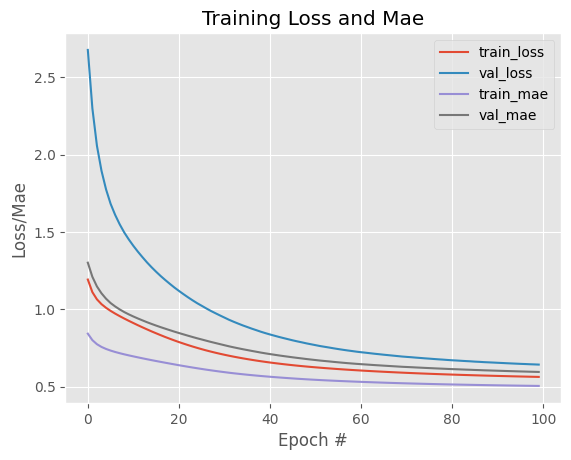

In [60]:
activation_function = tf.nn.relu
learning_rate = 0.001
lr_decay = 0.96
num_epochs = 100
batch_size = 64
predictions, model = train_deep_net(activation_function, learning_rate, lr_decay, batch_size, num_epochs)

In [61]:
# Conclusiones:
# 1. Observamos que el modelo aprende, tanto la pérdida en train como en val disminuyen de forma pronunciada en las 20 primers épocas (ganancia contra la aleatoriedad del inicio)
# 2. La MAE tiene un patrón similar a la pérdida lo que indica que la predicción de la variable objetivo mejora con las épocas
# 3. La curva de train MAE está por debajo de val MAE. Se considera esperable pues se espera mejor rendimiento en train
# 4. No parece haber sobreajuste (train y val MAE se mantienen "paralelas")
# 5. En base a la función de pérdidas vemos que el modelo tiene margen de mejora (la línea de validación está por encima de la de train)
# 6. En futuras iteraciones se podría aplicar técnicas de regularización, optimización y ajustes de hiperparámetros

In [62]:
# Revertimos la normalización aplicada para obtener precios reales de la predicción
y_norm_pred = np.array([0.93767923, -0.88585305, -0.24706554]).reshape(-1, 1)
y_norm_real = np.array([1.93062496, -0.81384023, -0.20780691]).reshape(-1, 1)

y_original_pred = scaler_y.inverse_transform(y_norm_pred)
y_original_real = scaler_y.inverse_transform(y_norm_real)

print(y_original_pred)
print(y_original_real)

[[274.97197313]
 [ 54.82599128]
 [131.94363001]]
[[394.84537216]
 [ 63.51974085]
 [136.68312914]]


In [63]:
from sklearn.metrics import mean_absolute_error

predictions_desnormalizadas = scaler_y.inverse_transform(predictions.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Calculamos el MAE en euros
mae_test_euros = mean_absolute_error(y_test_desnormalizado, predictions_desnormalizadas)
print(f"El MAE en el conjunto de prueba es de {mae_test_euros:.2f} euros")

El MAE en el conjunto de prueba es de 77.79 euros
